In [33]:
# Install necessary library
!pip install segmentation_models --quiet
!pip install -U tensorflow keras segmentation-models --quiet

In [34]:
# List existing image files (zipped)
!ls

cpu  landcoverai  landcoverai-20250306T133829Z-001.zip	models


In [35]:
pwd

'/project'

In [36]:
# Necessary because of a bug https://github.com/qubvel/segmentation_models/issues/374
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [37]:
!pip install matplotlib scikit-learn --quiet

In [38]:
import os
import random
from pathlib import Path

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models as sm
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [39]:
# In case the model gets very slow, may be due to a bug in TF2.0. Uncomment this.
# https://github.com/tensorflow/tensorflow/issues/33024
# tf.compat.v1.disable_eager_execution()

# Also check this in case you notice training to be getting increasingly slow each epoch.
# https://stackoverflow.com/questions/53683164/keras-occupies-an-indefinitely-increasing-amount-of-memory-for-each-epoch

In [40]:
# Define needed directory paths
dir_root = Path("/project/landcoverai/")
dir_train_img = Path(dir_root, "train_images/train/")
dir_train_mask = Path(dir_root, "train_masks/train/")
dir_val_img = Path(dir_root, "val_images/val/")
dir_val_mask = Path(dir_root, "val_masks/val/")
dir_models = Path("/project/models/")




# Show how many image files exist
for dir in [dir_train_img, dir_train_mask, dir_val_img, dir_val_mask]:
    files = patch_files = [file for file in dir.iterdir()]
    print(f"{dir} has {len(files)} images.")

/project/landcoverai/train_images/train has 2250 images.
/project/landcoverai/train_masks/train has 2250 images.
/project/landcoverai/val_images/val has 750 images.
/project/landcoverai/val_masks/val has 750 images.


In [41]:
classes = {
    0: "Not classified",
    1: "Building",
    2: "Woodland",
    3: "Water",
    4: "Roads",
}

### Visualize random patch alongside its mask

In [42]:
def plot_image_and_mask(image: Path):
    """
    Function to plot an image alongside its mask.
    """
    img = cv2.imread(image.as_posix())
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask_path = Path(image.as_posix().replace("/train_images/", "/train_masks/"))
    mask = cv2.imread(mask_path.as_posix())

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    ax1.imshow(img)
    ax1.set_title("Channel 0")

    norm = mpl.colors.Normalize(vmin=0, vmax=4)
    cmap = plt.get_cmap("viridis")

    ax2.imshow(mask[:, :, 1], cmap=cmap, norm=norm)
    ax2.set_title("Mask")

    plt.show()


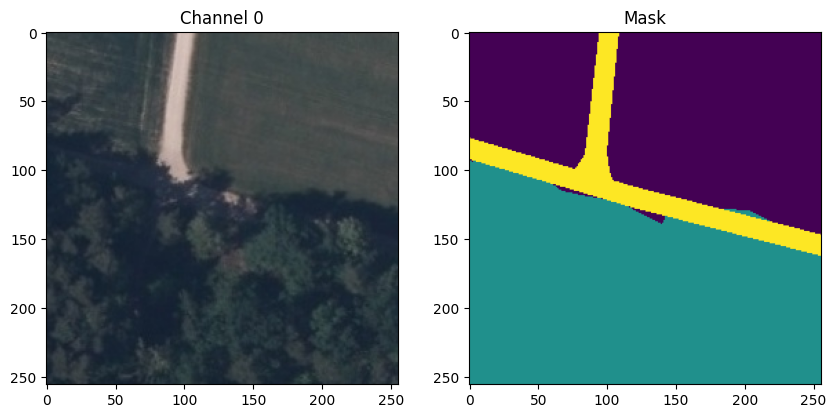

In [43]:
# Get paths of all images
img_files = [file for file in dir_train_img.iterdir()]

# Get random image from all images
img_path = np.random.choice(img_files)

plot_image_and_mask(img_path)


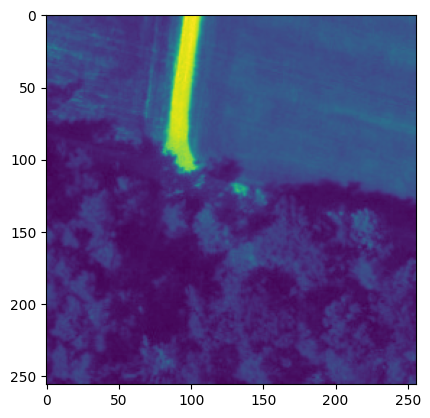

In [44]:
#Quick understanding of the dataset
temp_img = cv2.imread(img_path) #3 channels / spectral bands
plt.imshow(temp_img[:,:,0]) #View each channel...
plt.imshow(temp_img[:,:,1]) #View each channel...
plt.imshow(temp_img[:,:,2]) #View each channel...
temp_mask = cv2.imread(img_path) #3 channels but all same.






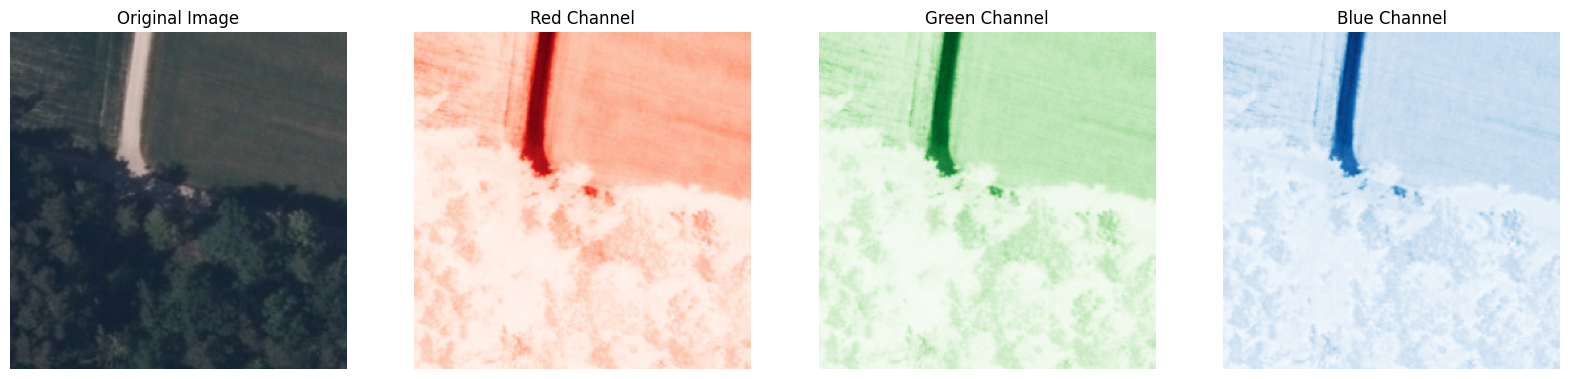

In [45]:


import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread(img_path)  # Reads in BGR format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Split the channels
red_channel = img[:, :, 0]  # Red channel
green_channel = img[:, :, 1]  # Green channel
blue_channel = img[:, :, 2]  # Blue channel

# Plot the channels
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(img)  # Original image
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(red_channel, cmap="Reds")
axs[1].set_title("Red Channel")
axs[1].axis("off")

axs[2].imshow(green_channel, cmap="Greens")
axs[2].set_title("Green Channel")
axs[2].axis("off")

axs[3].imshow(blue_channel, cmap="Blues")
axs[3].set_title("Blue Channel")
axs[3].axis("off")

plt.show()

In [46]:
labels, count = np.unique(temp_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)

Labels are:  [ 40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191]  and the counts are:  [   1    2    6   26   72  145  353  530 1009 1521 2095 2593 2733 2623
 2306 1951 1768 1570 1513 1468 1392 1378 1358 1366 1476 1429 1528 1508
 1499 1564 1550 1513 1992 2330 2863 3100 3041 2466 1928 1259  776  494
  339  256  185  170  112  101   74   57   50   46   46   38   40   29
   22   20   16   25   28   15   16   12   15   14    8   10   

In [47]:
import numpy as np

# Example: Assume temp_mask[:,:,0] contains many unique labels
labels, count = np.unique(temp_mask[:, :, 0], return_counts=True)
print("Original Labels:", labels)

# Create a mapping dictionary to reassign labels to [0,1,2,3,...]
# Ensure all labels in temp_mask are included in the mapping
label_mapping = {old_label: new_label for new_label, old_label in enumerate(labels)} #Changed labels[:4] to labels

# Apply mapping to mask
remapped_mask = np.vectorize(label_mapping.get)(temp_mask[:, :, 0])

# Print new unique labels
new_labels, new_count = np.unique(remapped_mask, return_counts=True)
print("New Labels:", new_labels)
print("New Counts:", new_count)

Original Labels: [ 40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191]
New Labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86 

### Define Generator for images and masks

In [48]:

import segmentation_models as sm

seed = 24
batch_size = 16  # Lower to 8 in case of memory issues
n_classes = len(classes)
encoder_freeze = True

# Use this to preprocess input for transfer learning
BACKBONE = "resnet101"
preprocess_input = sm.get_preprocessing(BACKBONE) # Now sm is defined and this line should work.

In [49]:
print(n_classes)

5


In [50]:
def preprocess_data(img, mask, num_class):
    """
    Function to perform additional preprocessing after datagen.
    """
    scaler = MinMaxScaler()

    # Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

    # Preprocess based on the pretrained backbone
    img = preprocess_input(img)

    # Convert mask to one-hot
    mask = to_categorical(mask, num_class)

    return (img, mask)


In [51]:


def trainGenerator(train_img_path, train_mask_path, num_class):
    """
    Function to define the generator.
    We are not doing any zoom to make sure mask values are not interpolated.
    It is important to keep pixel values in mask as 0, 1, 2, 3, ...
    """
    img_data_gen_args = dict(
        horizontal_flip=True, vertical_flip=True, fill_mode="reflect"
    )

    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        str(train_img_path),
        class_mode=None,
        batch_size=batch_size,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_directory(
        str(train_mask_path),
        class_mode=None,
        color_mode="grayscale",
        batch_size=batch_size,
        seed=seed,
    )

    train_generator = zip(image_generator, mask_generator)

    for img, mask in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [52]:
train_img_gen = trainGenerator(dir_train_img.parent, dir_train_mask.parent, num_class=n_classes)
val_img_gen = trainGenerator(dir_val_img.parent, dir_val_mask.parent, num_class=n_classes)

In [53]:
print(train_img_gen)
print(val_img_gen)

<generator object trainGenerator at 0x75f9ee3310e0>
<generator object trainGenerator at 0x75f9ee3316d0>


### Visualize some images to check

Make sure the generator is working and that images and masks are indeed lined up.

Found 2250 images belonging to 1 classes.
Found 2250 images belonging to 1 classes.
(16, 256, 256, 3) (16, 256, 256, 5)


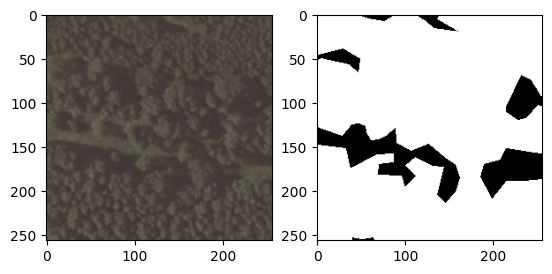

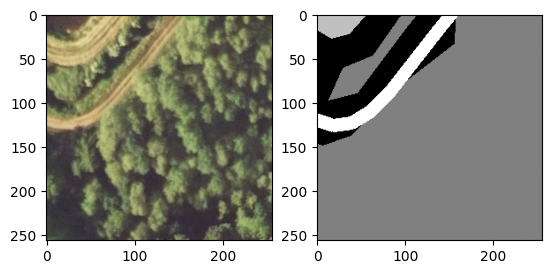

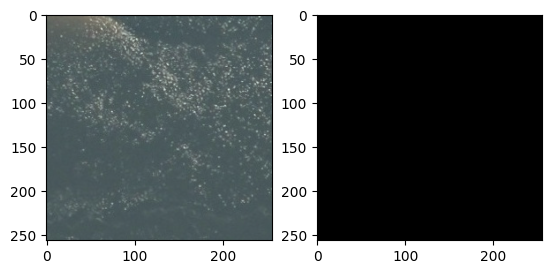

In [54]:
# Load the next batch of batch_size images
x, y = train_img_gen.__next__()

print(x.shape, y.shape)

# Make sure x has 3 layers (RGB)
assert x.shape[3] == 3

# Make sure y has n_classes layers
assert y.shape[3] == n_classes

for i in range(0, 3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.show()

Found 750 images belonging to 1 classes.
Found 750 images belonging to 1 classes.
(16, 256, 256, 3) (16, 256, 256, 5)


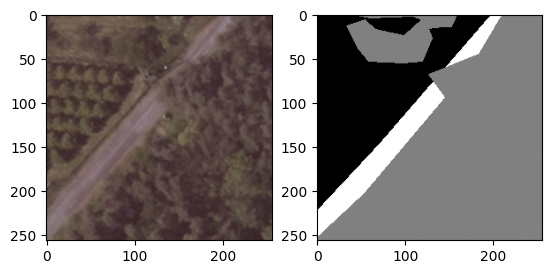

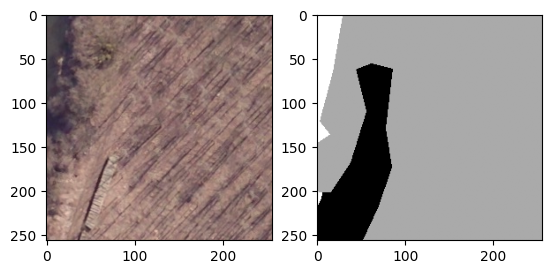

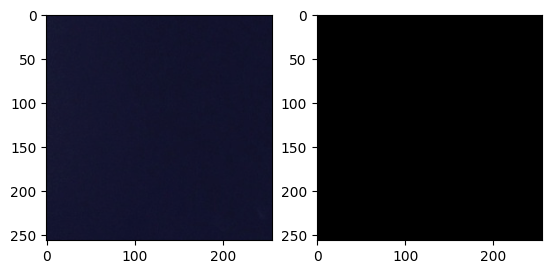

In [55]:
x_val, y_val = val_img_gen.__next__()

print(x_val.shape, y_val.shape)

# Make sure x has 3 layers (RGB)
assert x_val.shape[3] == 3

# Make sure y has n_classes layers
assert y_val.shape[3] == n_classes

for i in range(0, 3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.show()


### Define the model metrics and load model

In [56]:
num_train_imgs = len([file for file in dir_train_img.iterdir() if file.is_file()])
num_val_images = len([file for file in dir_val_img.iterdir() if file.is_file()])

steps_per_epoch = num_train_imgs // batch_size
val_steps_per_epoch = num_val_images // batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH = x.shape[2]
IMG_CHANNELS = x.shape[3]

EPOCHS = 75

In [57]:
print(num_train_imgs)
print(num_val_images)
print(steps_per_epoch)
print(val_steps_per_epoch)

2250
750
140
46


### Use transfer learning using pretrained encoder in the U-Net

We use ***Intersection over Union (IoU)*** as evaluation metric (see [here](https://towardsdatascience.com/iou-a-better-detection-evaluation-metric-45a511185be1)). is used when calculating Mean average precision (mAP). It is a number from 0 to 1 that specifies the amount of overlap between the predicted and ground truth bounding box:

- an IoU of 0 means that there is no overlap between the boxes
- an IoU of 1 means that the union of the boxes is the same as their overlap indicating that they are completely overlapping

In [58]:
# Define the model
model = sm.Unet(
    BACKBONE,
    encoder_weights="imagenet",
    encoder_freeze=encoder_freeze,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    classes=len(classes),
    activation="softmax",
)
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import tensorflow as  tf


def custom_iou_score(gt, pr, **kwargs):


    # Cast to float32 using Keras backend
    gt = tf.keras.backend.cast(gt, dtype='float32')
    pr = tf.keras.backend.cast(pr, dtype='float32')
    return sm.metrics.iou_score(gt, pr, **kwargs)


model.compile(
    "Adam",
    loss=sm.losses.categorical_focal_jaccard_loss,
    metrics=[custom_iou_score],
)

# Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

print(model.summary())
print(model.input_shape)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 256, 256,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_35   │ (None, 262, 262,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 128, 128,  │      9,408 │ zero_padding2d_3… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 128, 128,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 128, 128,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_36   │ (None, 130, 130,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 64, 64,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 64, 64,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 64, 64,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 64, 64,    │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 64, 64,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_37   │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 64, 64,    │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, 64, 64,    │          0 │ stage1_unit1_bn3

 Total params: 51,606,046 (196.86 MB)

 Trainable params: 9,111,448 (34.76 MB)

 Non-trainable params: 42,494,598 (162.10 MB)

None
(None, 256, 256, 3)


In [59]:
from keras.callbacks import EarlyStopping

stop_early = EarlyStopping(
    monitor="val_iou_score", patience=7, verbose=1, mode='max'
)

In [60]:
# Fit the model
history = model.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    verbose=1,
    validation_data=val_img_gen,
    validation_steps=val_steps_per_epoch,
    callbacks=stop_early,
)

freeze = "freeze" if encoder_freeze else "nofreeze"

file_model = Path(
    dir_models, f"landcover_{BACKBONE}_{EPOCHS}_epochs_batch{batch_size}_{freeze}.hdf5"
)
model.save(file_model)

Epoch 1/75
140/140 ━━━━━━━━━━━━━━━━━━━━ 118s 466ms/step - custom_iou_score: 0.3418 - loss: 0.6917 - val_custom_iou_score: 0.0989 - val_loss: 1.0414
Epoch 2/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - custom_iou_score: 0.6340 - loss: 0.3885

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 36s 258ms/step - custom_iou_score: 0.5643 - loss: 0.4701 - val_custom_iou_score: 0.0747 - val_loss: 1.1625
Epoch 3/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - custom_iou_score: 0.5658 - loss: 0.4598

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 36s 256ms/step - custom_iou_score: 0.5827 - loss: 0.4513 - val_custom_iou_score: 0.0736 - val_loss: 1.4092
Epoch 4/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - custom_iou_score: 0.5811 - loss: 0.4509

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 35s 252ms/step - custom_iou_score: 0.5995 - loss: 0.4327 - val_custom_iou_score: 0.0750 - val_loss: 1.3164
Epoch 5/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - custom_iou_score: 0.6391 - loss: 0.3852

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 33s 240ms/step - custom_iou_score: 0.5855 - loss: 0.4537 - val_custom_iou_score: 0.1018 - val_loss: 1.1151
Epoch 6/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - custom_iou_score: 0.7325 - loss: 0.2798

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 220ms/step - custom_iou_score: 0.6190 - loss: 0.4118 - val_custom_iou_score: 0.2573 - val_loss: 0.9836
Epoch 7/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - custom_iou_score: 0.6763 - loss: 0.3382

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 201ms/step - custom_iou_score: 0.6442 - loss: 0.3836 - val_custom_iou_score: 0.3326 - val_loss: 0.7786
Epoch 8/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - custom_iou_score: 0.6552 - loss: 0.3720

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 203ms/step - custom_iou_score: 0.6550 - loss: 0.3715 - val_custom_iou_score: 0.5946 - val_loss: 0.4364
Epoch 9/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - custom_iou_score: 0.7409 - loss: 0.2822

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 204ms/step - custom_iou_score: 0.6763 - loss: 0.3481 - val_custom_iou_score: 0.5653 - val_loss: 0.4852
Epoch 10/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - custom_iou_score: 0.5932 - loss: 0.4346

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 200ms/step - custom_iou_score: 0.6134 - loss: 0.4225 - val_custom_iou_score: 0.6180 - val_loss: 0.4146
Epoch 11/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step - custom_iou_score: 0.7179 - loss: 0.3132

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 201ms/step - custom_iou_score: 0.6680 - loss: 0.3595 - val_custom_iou_score: 0.6371 - val_loss: 0.3982
Epoch 12/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - custom_iou_score: 0.6441 - loss: 0.3789

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 202ms/step - custom_iou_score: 0.6599 - loss: 0.3711 - val_custom_iou_score: 0.6432 - val_loss: 0.3885
Epoch 13/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - custom_iou_score: 0.7181 - loss: 0.2973

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 203ms/step - custom_iou_score: 0.6572 - loss: 0.3746 - val_custom_iou_score: 0.5837 - val_loss: 0.4558
Epoch 14/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.7677 - loss: 0.2497

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 202ms/step - custom_iou_score: 0.6628 - loss: 0.3681 - val_custom_iou_score: 0.6427 - val_loss: 0.3874
Epoch 15/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - custom_iou_score: 0.6976 - loss: 0.3247

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 201ms/step - custom_iou_score: 0.6855 - loss: 0.3455 - val_custom_iou_score: 0.6455 - val_loss: 0.3893
Epoch 16/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - custom_iou_score: 0.6673 - loss: 0.3533

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - custom_iou_score: 0.6737 - loss: 0.3570 - val_custom_iou_score: 0.5554 - val_loss: 0.5010
Epoch 17/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step - custom_iou_score: 0.7267 - loss: 0.2948

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 201ms/step - custom_iou_score: 0.6051 - loss: 0.4338 - val_custom_iou_score: 0.6434 - val_loss: 0.3932
Epoch 18/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - custom_iou_score: 0.8057 - loss: 0.2054

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 202ms/step - custom_iou_score: 0.6799 - loss: 0.3502 - val_custom_iou_score: 0.6392 - val_loss: 0.3985
Epoch 19/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.7602 - loss: 0.2601

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 203ms/step - custom_iou_score: 0.6819 - loss: 0.3498 - val_custom_iou_score: 0.6125 - val_loss: 0.4310
Epoch 20/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - custom_iou_score: 0.7976 - loss: 0.2174

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 203ms/step - custom_iou_score: 0.6500 - loss: 0.3872 - val_custom_iou_score: 0.6113 - val_loss: 0.4333
Epoch 21/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - custom_iou_score: 0.7113 - loss: 0.3243

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 204ms/step - custom_iou_score: 0.6267 - loss: 0.4135 - val_custom_iou_score: 0.6256 - val_loss: 0.4130
Epoch 22/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step - custom_iou_score: 0.7749 - loss: 0.2427

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 203ms/step - custom_iou_score: 0.6463 - loss: 0.3879 - val_custom_iou_score: 0.6385 - val_loss: 0.4026
Epoch 23/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.7445 - loss: 0.2790

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 202ms/step - custom_iou_score: 0.6651 - loss: 0.3710 - val_custom_iou_score: 0.6382 - val_loss: 0.3993
Epoch 24/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - custom_iou_score: 0.7641 - loss: 0.2491

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 203ms/step - custom_iou_score: 0.6332 - loss: 0.4046 - val_custom_iou_score: 0.6085 - val_loss: 0.4294
Epoch 25/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - custom_iou_score: 0.7815 - loss: 0.2368

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - custom_iou_score: 0.6722 - loss: 0.3618 - val_custom_iou_score: 0.5822 - val_loss: 0.4617
Epoch 26/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - custom_iou_score: 0.7650 - loss: 0.2548

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 203ms/step - custom_iou_score: 0.6217 - loss: 0.4164 - val_custom_iou_score: 0.6120 - val_loss: 0.4338
Epoch 27/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.7671 - loss: 0.2491

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - custom_iou_score: 0.6349 - loss: 0.4042 - val_custom_iou_score: 0.6063 - val_loss: 0.4371
Epoch 28/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - custom_iou_score: 0.7799 - loss: 0.2369

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 203ms/step - custom_iou_score: 0.6568 - loss: 0.3741 - val_custom_iou_score: 0.5856 - val_loss: 0.4687
Epoch 29/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.7950 - loss: 0.2302

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 203ms/step - custom_iou_score: 0.6426 - loss: 0.3931 - val_custom_iou_score: 0.5886 - val_loss: 0.4620
Epoch 30/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.7112 - loss: 0.3075

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - custom_iou_score: 0.6188 - loss: 0.4210 - val_custom_iou_score: 0.5981 - val_loss: 0.4487
Epoch 31/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - custom_iou_score: 0.7966 - loss: 0.2231

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step - custom_iou_score: 0.6459 - loss: 0.3931 - val_custom_iou_score: 0.5143 - val_loss: 0.5571
Epoch 32/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - custom_iou_score: 0.7802 - loss: 0.2320

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - custom_iou_score: 0.5795 - loss: 0.4661 - val_custom_iou_score: 0.5724 - val_loss: 0.4848
Epoch 33/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - custom_iou_score: 0.7210 - loss: 0.2972

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step - custom_iou_score: 0.6347 - loss: 0.4041 - val_custom_iou_score: 0.4816 - val_loss: 0.5888
Epoch 34/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - custom_iou_score: 0.7647 - loss: 0.2503

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 208ms/step - custom_iou_score: 0.5656 - loss: 0.4793 - val_custom_iou_score: 0.4987 - val_loss: 0.5702
Epoch 35/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - custom_iou_score: 0.6636 - loss: 0.3437

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step - custom_iou_score: 0.5939 - loss: 0.4471 - val_custom_iou_score: 0.5236 - val_loss: 0.5458
Epoch 36/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - custom_iou_score: 0.7888 - loss: 0.2317

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step - custom_iou_score: 0.6000 - loss: 0.4430 - val_custom_iou_score: 0.5396 - val_loss: 0.5169
Epoch 37/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - custom_iou_score: 0.6909 - loss: 0.3334

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step - custom_iou_score: 0.6139 - loss: 0.4296 - val_custom_iou_score: 0.5114 - val_loss: 0.5545
Epoch 38/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - custom_iou_score: 0.7947 - loss: 0.2282

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 206ms/step - custom_iou_score: 0.6344 - loss: 0.4024 - val_custom_iou_score: 0.4992 - val_loss: 0.5715
Epoch 39/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step - custom_iou_score: 0.7190 - loss: 0.3009

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step - custom_iou_score: 0.5918 - loss: 0.4528 - val_custom_iou_score: 0.5498 - val_loss: 0.5119
Epoch 40/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - custom_iou_score: 0.8118 - loss: 0.2046

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - custom_iou_score: 0.6216 - loss: 0.4193 - val_custom_iou_score: 0.4953 - val_loss: 0.5769
Epoch 41/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - custom_iou_score: 0.7211 - loss: 0.2931

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 206ms/step - custom_iou_score: 0.5928 - loss: 0.4503 - val_custom_iou_score: 0.5362 - val_loss: 0.5240
Epoch 42/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - custom_iou_score: 0.7443 - loss: 0.2757

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 208ms/step - custom_iou_score: 0.5943 - loss: 0.4484 - val_custom_iou_score: 0.5395 - val_loss: 0.5248
Epoch 43/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - custom_iou_score: 0.7533 - loss: 0.2626

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step - custom_iou_score: 0.6201 - loss: 0.4218 - val_custom_iou_score: 0.5011 - val_loss: 0.5679
Epoch 44/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - custom_iou_score: 0.7081 - loss: 0.3088

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 208ms/step - custom_iou_score: 0.5875 - loss: 0.4571 - val_custom_iou_score: 0.5316 - val_loss: 0.5365
Epoch 45/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step - custom_iou_score: 0.7711 - loss: 0.2435

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step - custom_iou_score: 0.6233 - loss: 0.4174 - val_custom_iou_score: 0.5413 - val_loss: 0.5193
Epoch 46/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - custom_iou_score: 0.8038 - loss: 0.2121

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 206ms/step - custom_iou_score: 0.6238 - loss: 0.4157 - val_custom_iou_score: 0.5287 - val_loss: 0.5366
Epoch 47/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.7798 - loss: 0.2399

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 206ms/step - custom_iou_score: 0.6203 - loss: 0.4213 - val_custom_iou_score: 0.5133 - val_loss: 0.5514
Epoch 48/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - custom_iou_score: 0.6679 - loss: 0.3446

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 206ms/step - custom_iou_score: 0.5959 - loss: 0.4461 - val_custom_iou_score: 0.4902 - val_loss: 0.5891
Epoch 49/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - custom_iou_score: 0.8203 - loss: 0.1957

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - custom_iou_score: 0.5785 - loss: 0.4671 - val_custom_iou_score: 0.5022 - val_loss: 0.5645
Epoch 50/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 25s 182ms/step - custom_iou_score: 0.7549 - loss: 0.2626

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 206ms/step - custom_iou_score: 0.6093 - loss: 0.4356 - val_custom_iou_score: 0.5090 - val_loss: 0.5565
Epoch 51/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - custom_iou_score: 0.8492 - loss: 0.1581

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - custom_iou_score: 0.6154 - loss: 0.4265 - val_custom_iou_score: 0.5510 - val_loss: 0.5076
Epoch 52/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - custom_iou_score: 0.7191 - loss: 0.2949

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - custom_iou_score: 0.6359 - loss: 0.4029 - val_custom_iou_score: 0.5346 - val_loss: 0.5264
Epoch 53/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - custom_iou_score: 0.7784 - loss: 0.2345

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - custom_iou_score: 0.6101 - loss: 0.4308 - val_custom_iou_score: 0.5094 - val_loss: 0.5585
Epoch 54/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - custom_iou_score: 0.8246 - loss: 0.1850

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - custom_iou_score: 0.6050 - loss: 0.4362 - val_custom_iou_score: 0.5440 - val_loss: 0.5159
Epoch 55/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - custom_iou_score: 0.7987 - loss: 0.2147

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - custom_iou_score: 0.6176 - loss: 0.4235 - val_custom_iou_score: 0.5114 - val_loss: 0.5547
Epoch 56/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 24s 178ms/step - custom_iou_score: 0.7955 - loss: 0.2223

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - custom_iou_score: 0.6280 - loss: 0.4134 - val_custom_iou_score: 0.5254 - val_loss: 0.5451
Epoch 57/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 25s 182ms/step - custom_iou_score: 0.8105 - loss: 0.2087

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - custom_iou_score: 0.6084 - loss: 0.4361 - val_custom_iou_score: 0.5312 - val_loss: 0.5291
Epoch 58/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - custom_iou_score: 0.7597 - loss: 0.2625

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 203ms/step - custom_iou_score: 0.6041 - loss: 0.4372 - val_custom_iou_score: 0.7440 - val_loss: 0.2787
Epoch 59/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - custom_iou_score: 0.8317 - loss: 0.1810

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - custom_iou_score: 0.7870 - loss: 0.2289 - val_custom_iou_score: 0.5463 - val_loss: 0.5160
Epoch 60/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - custom_iou_score: 0.8402 - loss: 0.1750

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 206ms/step - custom_iou_score: 0.6153 - loss: 0.4288 - val_custom_iou_score: 0.5352 - val_loss: 0.5319
Epoch 61/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - custom_iou_score: 0.7897 - loss: 0.2382

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - custom_iou_score: 0.6144 - loss: 0.4281 - val_custom_iou_score: 0.5290 - val_loss: 0.5357
Epoch 62/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 24s 178ms/step - custom_iou_score: 0.7886 - loss: 0.2277

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 208ms/step - custom_iou_score: 0.6006 - loss: 0.4436 - val_custom_iou_score: 0.5630 - val_loss: 0.4947
Epoch 63/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 25s 183ms/step - custom_iou_score: 0.8123 - loss: 0.2056

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - custom_iou_score: 0.6091 - loss: 0.4338 - val_custom_iou_score: 0.2518 - val_loss: 1.0062
Epoch 64/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step - custom_iou_score: 0.8098 - loss: 0.2068

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 208ms/step - custom_iou_score: 0.6217 - loss: 0.4201 - val_custom_iou_score: 0.3992 - val_loss: 0.7531
Epoch 65/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 24s 177ms/step - custom_iou_score: 0.7850 - loss: 0.2336

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - custom_iou_score: 0.5890 - loss: 0.4598 - val_custom_iou_score: 0.5041 - val_loss: 0.5632
Epoch 66/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - custom_iou_score: 0.8171 - loss: 0.1977

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 199ms/step - custom_iou_score: 0.6013 - loss: 0.4451 - val_custom_iou_score: 0.7289 - val_loss: 0.2958
Epoch 67/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - custom_iou_score: 0.7901 - loss: 0.2274

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 200ms/step - custom_iou_score: 0.7960 - loss: 0.2206 - val_custom_iou_score: 0.5043 - val_loss: 0.5674
Epoch 68/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step - custom_iou_score: 0.8368 - loss: 0.1760

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step - custom_iou_score: 0.6167 - loss: 0.4288 - val_custom_iou_score: 0.5030 - val_loss: 0.5659
Epoch 69/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - custom_iou_score: 0.8358 - loss: 0.1744

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 203ms/step - custom_iou_score: 0.6124 - loss: 0.4336 - val_custom_iou_score: 0.4862 - val_loss: 0.6002
Epoch 70/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - custom_iou_score: 0.8715 - loss: 0.1373

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 200ms/step - custom_iou_score: 0.6038 - loss: 0.4425 - val_custom_iou_score: 0.5209 - val_loss: 0.5424
Epoch 71/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 123ms/step - custom_iou_score: 0.8411 - loss: 0.1680

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 194ms/step - custom_iou_score: 0.6081 - loss: 0.4362 - val_custom_iou_score: 0.7397 - val_loss: 0.2832
Epoch 72/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - custom_iou_score: 0.8416 - loss: 0.1756

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 202ms/step - custom_iou_score: 0.7941 - loss: 0.2222 - val_custom_iou_score: 0.5255 - val_loss: 0.5433
Epoch 73/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - custom_iou_score: 0.8051 - loss: 0.2090

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 201ms/step - custom_iou_score: 0.6312 - loss: 0.4093 - val_custom_iou_score: 0.5393 - val_loss: 0.5306
Epoch 74/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 24s 178ms/step - custom_iou_score: 0.8839 - loss: 0.1284

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 200ms/step - custom_iou_score: 0.6314 - loss: 0.4111 - val_custom_iou_score: 0.4935 - val_loss: 0.5784
Epoch 75/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - custom_iou_score: 0.7784 - loss: 0.2363

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 200ms/step - custom_iou_score: 0.6349 - loss: 0.4047 - val_custom_iou_score: 0.5005 - val_loss: 0.5702


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


### Plot training and validation IoU and loss at each epoch

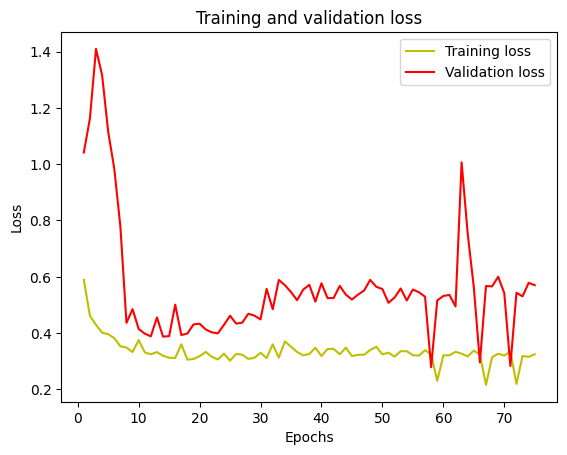

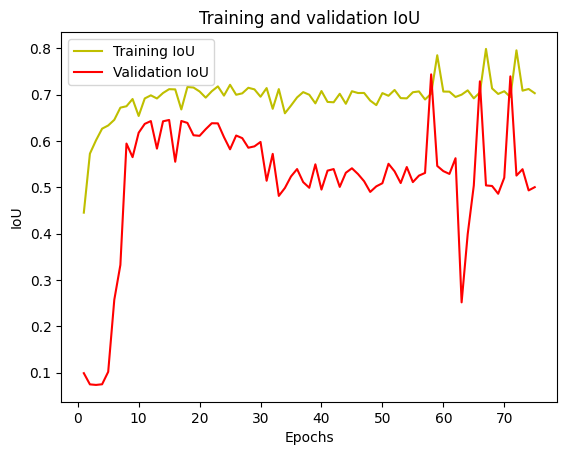

In [61]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "y", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["custom_iou_score"]
val_acc = history.history["val_custom_iou_score"]

plt.plot(epochs, acc, "y", label="Training IoU")
plt.plot(epochs, val_acc, "r", label="Validation IoU")
plt.title("Training and validation IoU")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.legend()
plt.show()

In [62]:
print(model.input_shape, model.output_shape)


(None, 256, 256, 3) (None, 256, 256, 5)


### Evaulate model on test data

In [63]:

model = load_model(file_model, compile=False)
model.save(file_model)
# Test generator using validation data.
test_image_batch, test_mask_batch = val_img_gen.__next__()

# Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Mean IoU = 0.7401459


## Calculation

- Accuracy is typically used for classification tasks, where the goal is to predict discrete classes. In semantic segmentation, accuracy measures the percentage of pixels that are correctly classified.

- R-squared (R2) is commonly used in regression problems to measure the goodness of fit. It's less relevant in semantic segmentation, which is primarily a classification task.
- Mean Squared Error (MSE) is a regression metric that quantifies the average squared difference between predicted and true values. In semantic segmentation, it can be applied to the pixel-wise probabilities or class labels. However, it might not be the most informative metric for this task.
- Loss is the function used to optimize the model during training. In semantic segmentation, various loss functions can be employed, such as categorical cross-entropy or Dice loss. The loss value reflects the model's overall performance during training.

In [64]:
# Access the loss value from the training history
loss = history.history['loss'][-1]  # Get the last loss value
print("Loss:", loss)

from sklearn.metrics import mean_squared_error

# Flatten predictions and ground truth
y_true_flat = test_mask_batch_argmax.flatten()  # Or use original probabilities
y_pred_flat = test_pred_batch_argmax.flatten()  # Or use original probabilities

# Calculate MSE
mse = mean_squared_error(y_true_flat, y_pred_flat)
print("Mean Squared Error:", mse)


from sklearn.metrics import accuracy_score

# Flatten predictions and ground truth
y_true_flat = test_mask_batch_argmax.flatten()
y_pred_flat = test_pred_batch_argmax.flatten()

# Calculate accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print("Accuracy:", accuracy)


# less Relevant
from sklearn.metrics import r2_score

# Assuming you have continuous predictions (e.g., probabilities)
y_true_flat = test_mask_batch.flatten()  # Use original probabilities
y_pred_flat = test_pred_batch.flatten()  # Use original probabilities

# Calculate R-squared
r2 = r2_score(y_true_flat, y_pred_flat)
print("R-squared:", r2)

Loss: 0.325003057718277
Mean Squared Error: 0.4546527862548828
Accuracy: 0.9422388076782227
R-squared: 0.8663795507607259


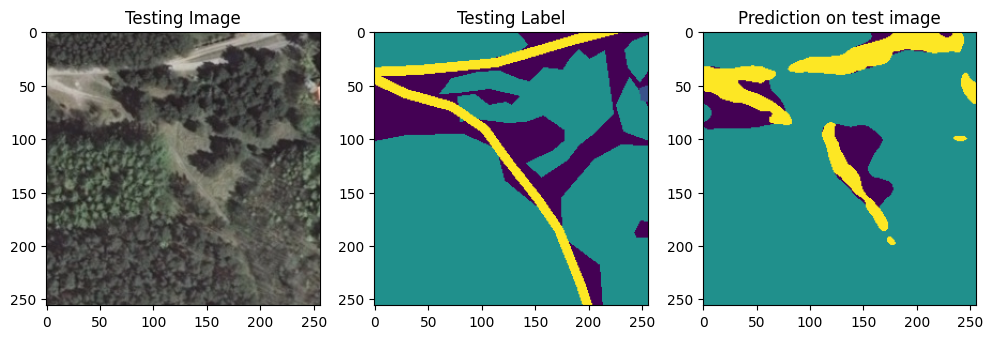

In [66]:
# View a few images, masks and corresponding predictions.
img_num = random.randint(0, test_image_batch.shape[0] - 1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title("Testing Image")
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title("Testing Label")
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title("Prediction on test image")
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()